In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
warnings.filterwarnings('ignore')

In [9]:
test=pd.read_csv('test.csv').iloc[:,:22]

In [10]:
Block=np.vstack((
    pd.read_csv('Blocks/Block 31.csv').iloc[:,:22].values,
    pd.read_csv('Blocks/Block 32.csv').iloc[:,:22].values
))


In [11]:
X_test_all=torch.FloatTensor((test.drop('label',axis=1).values)).cuda('cuda:0')
Y_test_all=             torch.LongTensor(test['label'].values).cuda('cuda:0')

In [14]:
X=torch.FloatTensor(Block[:,1:]).cuda('cuda:0')
Y=  torch.LongTensor(Block[:,0]).cuda('cuda:0')

In [16]:
# Xavier初始化权重

def xavier(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)

class MyNet(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.f1=nn.Linear(input_dim,input_dim*2)
        self.drop1=nn.Dropout(p=0.2)
        self.s1=nn.ReLU()
        
        self.f2=nn.Linear(input_dim*2,input_dim*3)
        self.drop2=nn.Dropout(p=0.35)
        self.s2=nn.ReLU()
        
        self.f3=nn.Linear(input_dim*3,input_dim*3)
        self.drop3=nn.Dropout(p=0.5)
        self.s3=nn.ReLU()    
        
        self.f4=nn.Linear(input_dim*3,input_dim*2)
        self.drop4=nn.Dropout(p=0.35)
        self.s4=nn.ReLU()
        
        self.f5=nn.Linear(input_dim*2,input_dim)
        self.drop5=nn.Dropout(p=0.2)
        self.s5=nn.ReLU()
        
        self.f6=nn.Linear(input_dim,2)   
        self.s6=nn.Softmax(dim=1)
        
    
    def forward(self,x):
        x=self.s1(self.drop1(self.f1(x)))
        x=self.s2(self.drop2(self.f2(x)))
        x=self.s3(self.drop3(self.f3(x)))
        x=self.s4(self.drop4(self.f4(x)))
        x=self.s5(self.drop5(self.f5(x)))
        return self.s6(self.f6(x))
        
#     预测
    def predict(self,x):
        x=self.s1(self.f1(x))
        x=self.s2(self.f2(x))
        x=self.s3(self.f3(x))
        x=self.s4(self.f4(x))
        x=self.s5(self.f5(x))
        p=self.s6(self.f6(x))
        return (p[:,0]<p[:,1])
    
#     准确率 
    def acc(self,x,y):
        with torch.no_grad():
            return float(((self.predict(x)==y).sum()/len(y)))

In [18]:
net=MyNet(X.shape[1]).cuda("cuda:0")
# net.apply(xavier);
net

MyNet(
  (f1): Linear(in_features=21, out_features=42, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (s1): ReLU()
  (f2): Linear(in_features=42, out_features=63, bias=True)
  (drop2): Dropout(p=0.35, inplace=False)
  (s2): ReLU()
  (f3): Linear(in_features=63, out_features=63, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (s3): ReLU()
  (f4): Linear(in_features=63, out_features=42, bias=True)
  (drop4): Dropout(p=0.35, inplace=False)
  (s4): ReLU()
  (f5): Linear(in_features=42, out_features=21, bias=True)
  (drop5): Dropout(p=0.2, inplace=False)
  (s5): ReLU()
  (f6): Linear(in_features=21, out_features=2, bias=True)
  (s6): Softmax(dim=1)
)

In [19]:
# 用于绘制曲线
losses=[]
train_acc=[]
test_acc=[]

# 用于随机抽测试集
idx=list(range(len(test)))

n_train=len(X)

In [24]:
optimizer=torch.optim.Adam(net.parameters(), lr=0.011, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion=torch.nn.CrossEntropyLoss()
epochs=5000


for i in range(epochs):
    
    y_pred=net.forward(X)
    loss=criterion(y_pred,Y)
    

    if(i%100)==0:
        losses.append(float(loss))
        train_acc.append( net.acc(X,Y) )
        
        np.random.shuffle(idx)
        
        X_test=X_test_all[idx[n_train:n_train*2]].cuda('cuda:0')
        Y_test=Y_test_all[idx[n_train:n_train*2]].cuda('cuda:0')
        
        test_acc.append(net.acc(X_test,Y_test))
        
    if(i%(int(epochs*0.1))==0):
        print(str((i/epochs)*100)+'%',end='\t')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print('100%')
torch.save(net.state_dict(),'Params/1_21/Net_'+str(len(train_acc)*100)+'.params')


0.0%	10.0%	20.0%	30.0%	40.0%	50.0%	60.0%	70.0%	80.0%	90.0%	100%


epoch: 5200
Train acc:  0.6787240505218506
Test acc:   0.6725682020187378


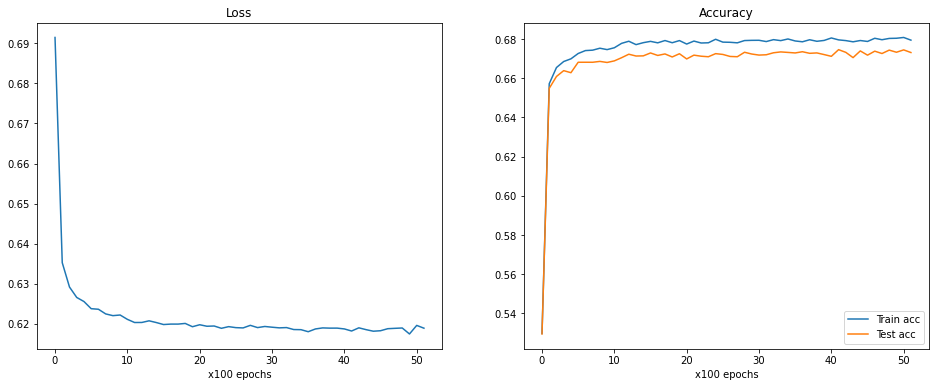

In [25]:
%matplotlib inline
fig,ax=plt.subplots(1,2,figsize=(16,6))

ax[0].set_xlabel('x100 epochs')
ax[0].set_title('Loss')
ax[0].plot(   losses,label='Train loss')
ax[1].plot(train_acc,label='Train acc')
ax[1].plot( test_acc,label='Test acc')
ax[1].set_xlabel('x100 epochs')
ax[1].set_title('Accuracy')

plt.legend()
print('epoch: '+str(len(train_acc*100)))
print('Train acc: ',net.acc(X,Y))
print('Test acc:  ',net.acc(X_test,Y_test))

## 4142

In [26]:
Block=np.vstack((
    pd.read_csv('Blocks/Block 41.csv').iloc[:,:22].values,
    pd.read_csv('Blocks/Block 42.csv').iloc[:,:22].values
))


In [27]:
X= torch.FloatTensor(Block[:,1:]).cuda('cuda:0')
Y=  torch.LongTensor(Block[:,0]).cuda('cuda:0')

In [28]:
optimizer=torch.optim.Adam(net.parameters(), lr=0.011, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion=torch.nn.CrossEntropyLoss()
epochs=5000


for i in range(epochs):
    
    y_pred=net.forward(X)
    loss=criterion(y_pred,Y)
    

    if(i%100)==0:
        losses.append(float(loss))
        train_acc.append( net.acc(X,Y) )
        
        np.random.shuffle(idx)
        
        X_test=X_test_all[idx[n_train:n_train*2]].cuda('cuda:0')
        Y_test=Y_test_all[idx[n_train:n_train*2]].cuda('cuda:0')
        
        test_acc.append(net.acc(X_test,Y_test))
        
    if(i%(int(epochs*0.1))==0):
        print(str((i/epochs)*100)+'%',end='\t')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print('100%')
torch.save(net.state_dict(),'Params/1_21/Net_'+str(len(train_acc)*100)+'.params')


0.0%	10.0%	20.0%	30.0%	40.0%	50.0%	60.0%	70.0%	80.0%	90.0%	100%


epoch: 10200
Train acc:  0.680490255355835
Test acc:   0.6753896474838257


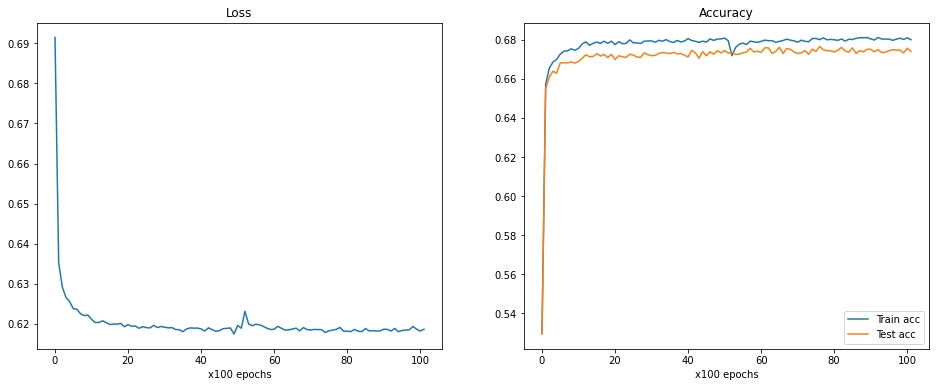

In [29]:
%matplotlib inline
fig,ax=plt.subplots(1,2,figsize=(16,6))

ax[0].set_xlabel('x100 epochs')
ax[0].set_title('Loss')
ax[0].plot(   losses,label='Train loss')
ax[1].plot(train_acc,label='Train acc')
ax[1].plot( test_acc,label='Test acc')
ax[1].set_xlabel('x100 epochs')
ax[1].set_title('Accuracy')

plt.legend()
print('epoch: '+str(len(train_acc*100)))
print('Train acc: ',net.acc(X,Y))
print('Test acc:  ',net.acc(X_test,Y_test))